# Uniform Circular Array

### Creation of the array
We consider an uniform circular array of $N_{ant}$ antenna. The system function for $fc = 2.4GHz$. The frequency sample of the system is $fs = 64.MHz$. A signal is emitted from a $T_x$ antenna at a certain position. The goal is to definite the direction of arrival of the $T_x$ signal. 

According to antialisaing, the space between antenna is defined to $\lambda/2$.\
Here, we work in the $XY$ plan. Differents DOA methods will be consider such as <u>beamforming</u>, <u>CAPON</u>, <u>MUSIC</u>. 

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.fft import ifftshift

In [2]:
sys.path.append('./Library')
import TDS_perso

In [3]:
# Constant 
CELERITY_LIGHT = 299792458

# Physical parameters
fc = 2.4e9
lambdaVal = CELERITY_LIGHT/fc

In [4]:
# systems variables Rx
fs_Rx = 20e6
Nech_Rx = 2**14
print("Parametres Rx : fs = ", fs_Rx/1e6, "MHz, Nech = ", Nech_Rx )

GainRx = 2
GainRxLin = 10**(GainRx/10) # Attention à mettre le gain en lineaire


Parametres Rx : fs =  20.0 MHz, Nech =  16384


In [5]:
# systems variables Tx
fs_Tx = 11.2e6 #(ex DJI)
Nech_Tx = 2**12
print("Parametres Tx : fs = ", fs_Tx/1e6, "MHz, Nech = ", Nech_Tx )

# parametres systemes
sigPowdBm = 18  #dBm
R         = 50 #charge de 50 ohm
sigPowLin = 10**((sigPowdBm-30)/10) # conversion en Watts

GainTx    = 2
GainTxLin = 10**(GainTx/10) # Attention à mettre le gain en lineaire


Parametres Tx : fs =  11.2 MHz, Nech =  4096


In [6]:
def uniform_circular_array(N, R, center=(0, 0, 0)):
    """
    Génère les coordonnées d'un Uniform Circular Array (UCA).
    
    Args:
        N (int): nombre d'éléments
        R (float): rayon du cercle
        center (tuple): coordonnées (x0, y0, z0) du centre
        
    Returns:
        np.ndarray: tableau de forme (N, 3) contenant les positions (x,y,z)
    """
    x0, y0, z0 = center
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)  # angles équidistants
    x = x0 + R * np.cos(angles)
    y = y0 + R * np.sin(angles)
    z = np.full(N, z0)  # tous les points dans le plan XY
    return np.vstack((x, y, z)).T

Coordonnées des antennes :
 [[ 7.95224193e-02  0.00000000e+00  0.00000000e+00]
 [ 5.62308420e-02  5.62308420e-02  0.00000000e+00]
 [ 4.86934381e-18  7.95224193e-02  0.00000000e+00]
 [-5.62308420e-02  5.62308420e-02  0.00000000e+00]
 [-7.95224193e-02  9.73868763e-18  0.00000000e+00]
 [-5.62308420e-02 -5.62308420e-02  0.00000000e+00]
 [-1.46080314e-17 -7.95224193e-02  0.00000000e+00]
 [ 5.62308420e-02 -5.62308420e-02  0.00000000e+00]]


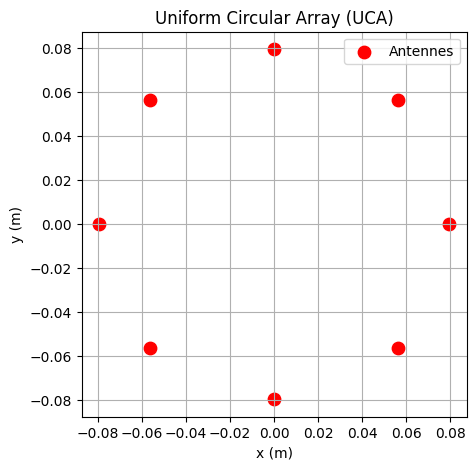

In [7]:
# Exemple d'utilisation
N_ant = 8      # nombre d'antennes
R = N_ant*lambdaVal/4/np.pi    # rayon en mètres # longueur optimal pour UCA, distance entre antennes = \lambda/2
uca = uniform_circular_array(N_ant, R)

print("Coordonnées des antennes :\n", uca)

# Visualisation 2D
plt.figure(figsize=(5,5))
plt.scatter(uca[:,0], uca[:,1], c='red', s=80, label="Antennes")
plt.gca().set_aspect("equal")
plt.title("Uniform Circular Array (UCA)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(True)
plt.legend()
plt.show()

Nombre de Tx :  1
Radial distance of Tx from the center of the array  [70.71067812] m
True elevation [34.44990199]
True azimut [59.03624347]


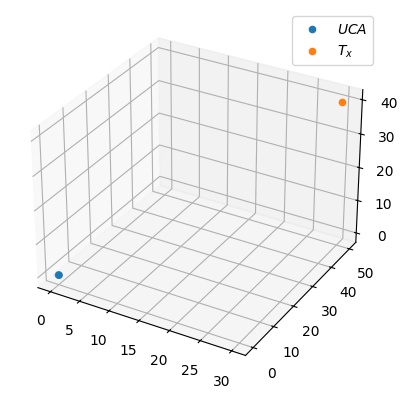

In [8]:
# define position of the Tx
x_pos_Tx = [[30, -40, -118]]
y_pos_Tx = [[50, 77, 20]]
z_pos_Tx = [[40, 80, 37]]
# define position of the Tx
x_pos_Tx = [[30]]
y_pos_Tx = [[50]]
z_pos_Tx = [[40]]
pos_Tx = np.concatenate((x_pos_Tx,y_pos_Tx,z_pos_Tx), axis = 0)
n_Tx = len(pos_Tx[0,:])
print("Nombre de Tx : ", n_Tx)

# calculation of the radial distance
dist_from_origine = np.sqrt(pos_Tx[0,:]**2+pos_Tx[1,:]**2+pos_Tx[2,:]**2)
print("Radial distance of Tx from the center of the array ", dist_from_origine, "m")


# caluclation of the true doa 
# elevation
trueElevation = np.atan2(pos_Tx[2,:], np.sqrt(pos_Tx[0,:]**2 + pos_Tx[1,:]**2))
print("True elevation", np.rad2deg(trueElevation))

trueAzimut = np.atan2(pos_Tx[1,:], pos_Tx[0,:])
print("True azimut", np.rad2deg(trueAzimut))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(uca[0,:], uca[1,:], uca[2,:], label="$UCA$")
ax.scatter(pos_Tx[0,:], pos_Tx[1,:], pos_Tx[2,:], label="$T_x$")
ax.legend()
ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.grid()

In [9]:
# generation of a signal 
bandwidth = 10e6
NumberBloc = 4
signal, timeV, params, dataframe = TDS_perso.generationWIMAX(bandwidth, NumberBloc)
Nech = len(signal)

fs = :  11.2 MHz
Bloc Symbol duration : 102.9 micros


In [10]:
# calculation of the freeloss space
H, distances, retards = TDS_perso.champ_libre_mimo(pos_Tx, uca.T, fc)

signalPathLoss = np.zeros((len(signal), N_ant, n_Tx), dtype = "complex")
# generate a signal for each signal
for ind in range(n_Tx):
    signal, timeV, params, dataframe = TDS_perso.generationWIMAX(bandwidth, NumberBloc)
    signalPathLoss[:,:,ind] = np.sqrt(sigPowLin*GainRxLin*GainTxLin)*signal*H[:,ind]

if n_Tx>1:
    signalPathLoss = np.sum(signalPathLoss, axis=2)
else:
    signalPathLoss = np.squeeze(signalPathLoss)

fs = :  11.2 MHz
Bloc Symbol duration : 102.9 micros


<b>Definition du steering vector</b>
le steering vector est construit de la maniere suivante:
$$ s = e^{-2\pi pu/\lambda}$$

avec $p$ est la position des elements du reseau, $u$ le veceur de direction que l'on veut observer, et $\lambda$ la longueur d'onde du système. 
Par rapport aux coordonnées spherique, on defini les vecteurs de positions du systèmes avec les coordonnées sphériques:
$$ x = cos(\theta)cos(\phi)$$
$$ y = sin(\theta)cos(\phi)$$
$$ z = sin(\phi)$$


In [12]:
print(fc)
def steering_vector_uca(posRX, theta, phi,fc,  c=CELERITY_LIGHT):
    """
    Steering vector d'un UCA (Uniform Circular Array) en 3D.
    
    Args:
        posRX (array): Rx antenna position array (Nant x 3)
        theta (array): angles d'azimut (radians)
        phi (array): angles d'élévation (radians)
        c (float): vitesse de propagation (m/s)
        
    Returns:
        np.ndarray: steering vector (len(theta), len(phi), N)
    
    """
    k = 2*np.pi*fc/c
    N = posRX.shape[0]
        
    # Génération des vecteurs d'onde k pour toutes les directions
    theta, phi = np.meshgrid(theta, phi, indexing="ij")  # grilles d'angles
    kx = k * np.cos(theta) * np.cos(phi)
    ky = k * np.sin(theta) * np.cos(phi)
    kz = k * np.sin(phi)
    
    # Calcul steering vector
    a = np.zeros((*theta.shape, N), dtype=complex)
    for n in range(N):
        phase = kx * posRX[n,0] + ky * posRX[n,1] + kz * posRX[n,2]
        a[..., n] = np.exp(-1j * phase)
    
    return a

# Exemple : UCA 8 antennes, 2.4 GHz
N = 8
f = 2.4e9
theta = np.linspace(0, 2*np.pi, 180)   # azimut
phi = np.linspace(0, np.pi/2, 90)      # élévation

steerVect = steering_vector_uca(uca, theta, phi, fc)

print("Shape du steering vector :", steerVect.shape)  # (180, 90, N)


2400000000.0
Shape du steering vector : (180, 90, 8)


Text(0, 0.5, 'elevation ($\\phi$)')

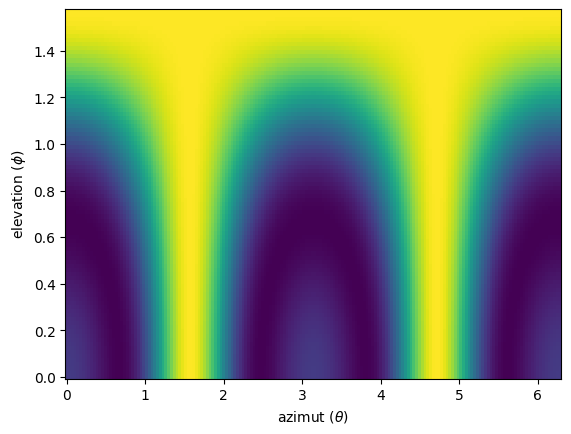

In [13]:
plt.figure()
plt.pcolormesh(theta, phi, np.real(steerVect[:,:,4].T))
plt.xlabel(r'azimut ($\theta$)')
plt.ylabel(r'elevation ($\phi$)')

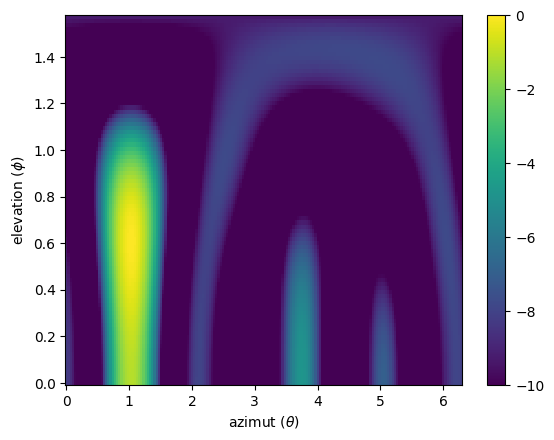

In [14]:
Rxx = np.dot(signalPathLoss.T.conj(), signalPathLoss)/Nech

# beamforming 2D
beamforming = np.zeros((len(theta), len(phi)), dtype = float)

# along azimut axis
for i_theta in range(len(theta)):
    for i_phi in range(len(phi)):
        beamforming[i_theta, i_phi] = np.abs(steerVect[i_theta, i_phi, :].squeeze().conj()@Rxx@steerVect[i_theta, i_phi, :].squeeze().T)
        
beamforming = beamforming/np.max(beamforming) # normalisation

plt.figure()
plt.pcolormesh(theta, phi, 10*np.log10(beamforming).T, vmin=-10)
plt.xlabel(r'azimut ($\theta$)')
plt.ylabel(r'elevation ($\phi$)')
plt.colorbar()
plt.show()

True elevation [34.44990199]
True azimut [59.03624347]


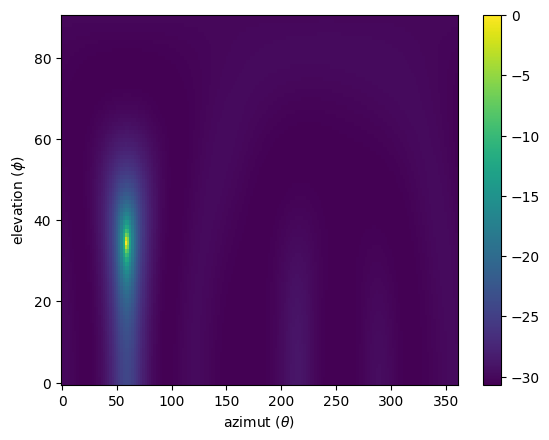

In [15]:
# CAPON
Rxx_inv = np.linalg.pinv(Rxx + 1e-16*np.eye(Rxx.shape[0]))
capon = np.zeros((len(theta), len(phi)), dtype = float)
for i_theta in range(len(theta)):
    for i_phi in range(len(phi)):
        capon[i_theta, i_phi] = 1/np.abs((steerVect[i_theta, i_phi,:].squeeze().conj()@Rxx_inv@steerVect[i_theta, i_phi,:].squeeze().T))
        capon[i_theta, i_phi] = np.abs(steerVect[i_theta, i_phi,:].squeeze().conj()@steerVect[i_theta, i_phi,:].squeeze().T)/np.abs((steerVect[i_theta, i_phi,:].squeeze().conj()@Rxx_inv@steerVect[i_theta, i_phi,:].squeeze().T))

capon = capon/np.max(capon) # normalisation

print("True elevation", np.rad2deg(trueElevation))
print("True azimut", np.rad2deg(trueAzimut))
plt.figure()
plt.pcolormesh(np.rad2deg(theta), np.rad2deg(phi), 10*np.log10(capon).T)
plt.xlabel(r'azimut ($\theta$)')
plt.ylabel(r'elevation ($\phi$)')
plt.colorbar()
plt.show()

N source : 1
True elevation [34.45] degrees
True azimut [59.04] degrees


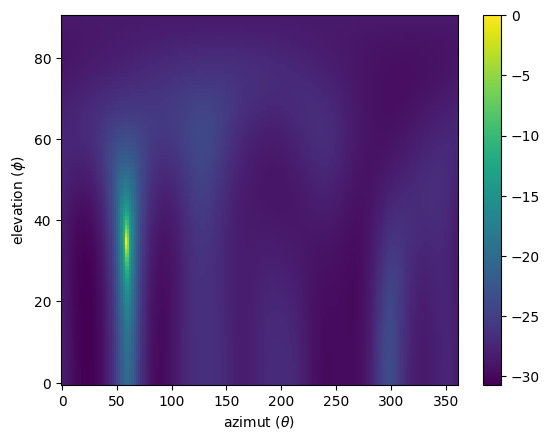

In [16]:
# MUSIC
nsource = n_Tx
print("N source :", nsource)
eigVal, eigVect = np.linalg.eig(Rxx)
idx = np.argsort(eigVal)[::-1]
eigVect = eigVect[:, idx]
EE = eigVect[:, nsource:]@eigVect[:, nsource:].T.conj()

music = np.zeros((len(theta), len(phi)), dtype = float)
for i_theta in range(len(theta)):
    for i_phi in range(len(phi)):
        music[i_theta, i_phi] = 1/np.abs(steerVect[i_theta, i_phi,:].conj()@EE@steerVect[i_theta, i_phi,:].T)
        music[i_theta, i_phi] = np.abs(steerVect[i_theta, i_phi,:].conj()@steerVect[i_theta, i_phi,:].T)/np.abs(steerVect[i_theta, i_phi,:].conj()@EE@steerVect[i_theta, i_phi,:].T)
music = music/np.max(music) # normalisation


print("True elevation", np.round(np.rad2deg(trueElevation),2), "degrees")
print("True azimut", np.round(np.rad2deg(trueAzimut), 2), "degrees")
plt.figure()
plt.pcolormesh(np.rad2deg(theta), np.rad2deg(phi), 10*np.log10(music).T)
plt.xlabel(r'azimut ($\theta$)')
plt.ylabel(r'elevation ($\phi$)')
plt.colorbar()
plt.show()
